<a href="https://colab.research.google.com/github/SaiDhanyaa/DEEP_LEARNING/blob/main/DL_HW_3_FINAL_VERSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the required packages:
!pip install networkx node2vec matplotlib scikit-learn


In [2]:
# Import necessary libraries
import networkx as nx               # NetworkX for network analysis
from node2vec import Node2Vec       # Node2Vec library for generating node embeddings
from sklearn.cluster import KMeans  # KMeans from scikit-learn for clustering
import matplotlib.pyplot as plt     # Matplotlib for plotting

**Prepare the Data:**

Load the Karate Club graph using NetworkX:

In [3]:
# Load the Zachary's Karate Club graph from NetworkX
G = nx.karate_club_graph()

In [4]:
# Initialize Node2Vec model with specified parameters
node2vec = Node2Vec(
    G,                              # The graph on which embeddings will be learned
    dimensions=64,                  # The number of dimensions of the embeddings
    walk_length=30,                 # The length of each walk
    num_walks=200,                  # The number of walks from each node
    workers=4                       # The number of worker threads to use
)

# Train the Node2Vec model
model = node2vec.fit(
    window=10,                      # The maximum distance between the current and predicted node in a walk
    min_count=1,                    # The minimum count of nodes to consider when training the model
    batch_words=4                   # The size of batches for training the model
)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

**Evaluate the Embeddings**

We'll evaluate the embeddings by performing a clustering task and visualizing it. The Karate Club has a known community structure that we can use to validate our embeddings. We can use k-means clustering to see if embeddings from the same community tend to cluster together.

**1. Generate Embeddings:**

Extract embeddings for each node:

In [5]:
# Retrieve embeddings from the model
embeddings = model.wv.vectors

**2. Cluster Embeddings:**

Apply k-means clustering:

In [6]:
# Perform K-means clustering on the embeddings
kmeans = KMeans(
    n_clusters=2,                   # Number of clusters to form (Karate Club has two factions)
    random_state=42                 # Random state for reproducibility
).fit(embeddings)

# Get the cluster labels for each node
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**3. Visualize the Clusters:**

Visualize the results to see if nodes in the same community are clustered together:

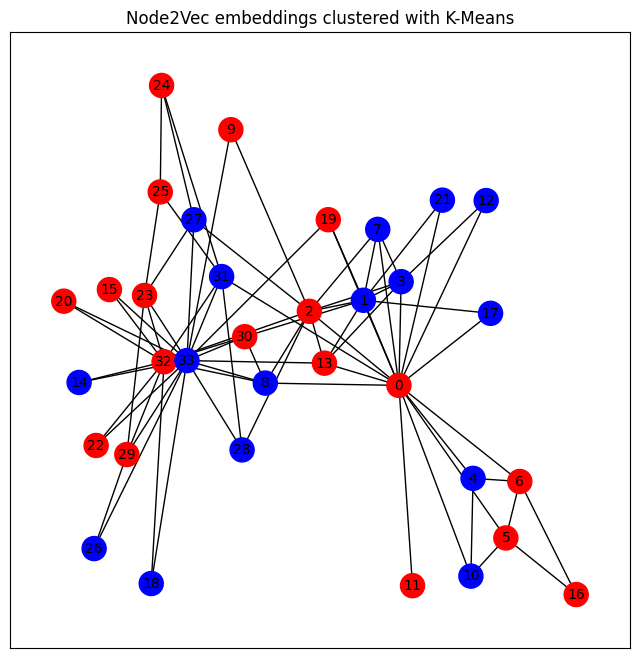

In [7]:
# Create a color map for visualizing different clusters
color_map = {0: 'blue', 1: 'red'}
# Map the labels to colors
colors = [color_map[label] for label in labels]
# Draw the graph with nodes colored according to their cluster assignment
plt.figure(figsize=(8, 8))
nx.draw_networkx(
    G,                              # The graph
    node_color=colors,              # Colors of the nodes
    with_labels=True,               # Show node labels (node IDs)
    node_size=300,                  # Size of the nodes
    font_size=10                    # Font size for node labels
)
plt.title('Node2Vec embeddings clustered with K-Means')
plt.show()

**4. Quantitative Evaluation:**

Use metrics like Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI):

The Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) are both metrics used to compare the similarity of two clusterings. The values for both ARI and NMI range from -1 to 1 and 0 to 1, respectively. Here's what the values indicate:

Adjusted Rand Index (ARI):

* -1 indicates perfect disagreement between the two clusterings.
* 0 indicates random clustering (no better than chance).
* 1 indicates perfect agreement between the two clusterings.

Normalized Mutual Information (NMI):

* 0 indicates no mutual information (independent labelings).
* 1 indicates perfect correlation between the two clusterings.

In [8]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# True labels based on the known community split in the Karate Club
true_labels = [data['club'] for _, data in G.nodes(data=True)]
true_labels = [0 if label == 'Mr. Hi' else 1 for label in true_labels]

# Calculate Adjusted Rand Index and Normalized Mutual Information
ari = adjusted_rand_score(true_labels, labels)
nmi = normalized_mutual_info_score(true_labels, labels)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")


Adjusted Rand Index: -0.0169
Normalized Mutual Information: 0.0101


## **Interpreting the Results**

**Adjusted Rand Index (ARI)**

**Value:** -0.0169

Interpretation: The ARI is slightly below 0, which indicates less agreement between the clustering and the true community labels than would be expected by random chance. This implies that the clustering is somewhat discordant with the actual community divisions.

**Normalized Mutual Information (NMI)**

**Value:** 0.0101

**Interpretation:** The NMI is close to 0, suggesting that there is very little mutual information between the clustering results and the true labels. Essentially, the clusters you found do not provide much information about the community structure.

## **Steps to Improve**

**Tune Node2Vec Parameters:**

Experiment with different settings for p and q to influence the likelihood of revisiting a node or exploring further nodes, which could help in better capturing community structures.

**Experiment with Other Clustering Methods:**

Try different clustering algorithms that might be more suitable for capturing the nuances in graph-based embeddings.

**Feature Scaling:**

Sometimes, scaling the features (embeddings) before clustering can help improve the clustering results as K-means is sensitive to the scale of the data.

**Increase Data:**

If possible, using a larger graph with more defined community structures might provide more distinct clusters in embeddings.

# **HYPER PARAMEETER TUNING TO GET THE BEST PARAMS AND IMPROVE THE ARI and NMI**

In [ ]:
param_grid = {
    'dimensions': [10, 20, 30, 40, 50],
    'walk_length': [40, 80, 120],
    'num_walks': [10, 50, 100],
    'p': [0.25, 0.50, 1, 2, 4],
    'q': [0.25, 0.50, 1, 2, 4],
    'window': [5, 10, 15],
    'min_count': [1, 2, 5]
}

# You should also set up the true_labels as they are needed for evaluation
true_labels = [data['club'] for _, data in G.nodes(data=True)]
true_labels = [0 if label == 'Mr. Hi' else 1 for label in true_labels]

best_ari = -1  # ARI ranges from -1 to 1
best_nmi = 0   # NMI ranges from 0 to 1
best_params = None

# Nested loops for grid search
for dimensions in param_grid['dimensions']:
    for walk_length in param_grid['walk_length']:
        for num_walks in param_grid['num_walks']:
            for p in param_grid['p']:
                for q in param_grid['q']:
                    for window in param_grid['window']:
                        for min_count in param_grid['min_count']:
                            # Initialize and train the Node2Vec model
                            node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks,
                                                p=p, q=q, workers=4, seed=42)
                            model = node2vec.fit(window=window, min_count=min_count, batch_words=4)

                            # Get the node embeddings and perform clustering
                            embeddings = model.wv.vectors
                            kmeans = KMeans(n_clusters=2, random_state=42).fit(embeddings)
                            labels = kmeans.labels_

                            # Evaluate the clustering
                            ari = adjusted_rand_score(true_labels, labels)
                            nmi = normalized_mutual_info_score(true_labels, labels)

                            # If the current model's ARI or NMI is the best, save the parameters and the score
                            if ari > best_ari or nmi > best_nmi:
                                best_ari = ari
                                best_nmi = nmi
                                best_params = {
                                    'dimensions': dimensions, 'walk_length': walk_length, 'num_walks': num_walks,
                                    'p': p, 'q': q, 'window': window, 'min_count': min_count
                                }

# Output the best results
print(f"Best ARI: {best_ari:.4f}")
print(f"Best NMI: {best_nmi:.4f}")
print(f"Best Parameters: {best_params}")


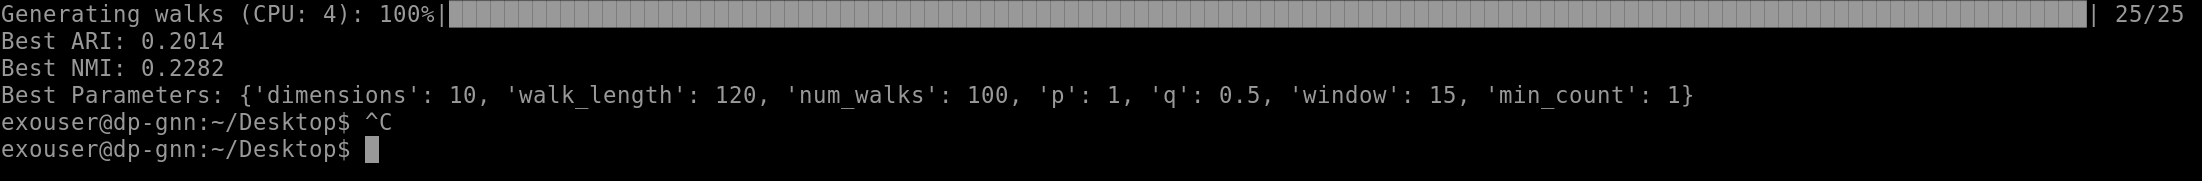

Best ARI: 0.2014

Best NMI: 0.2282

Best Parameters: {'dimensions': 10, 'walk_length': 120, 'num_walks': 100, 'p': 1, 'q': 0.5, 'window': 15, 'min_count': 1}

**The improved results from your parameter tuning indicate that the Node2Vec model is now generating embeddings that better reflect the known community structure within the Zachary's Karate Club network. Here's an interpretation of what the results mean:**

**Adjusted Rand Index (ARI)**

Value: 0.2014

Interpretation: The ARI has increased from a value close to 0 (indicating random chance) to a value clearly above 0, which suggests a fair agreement between the clustering assignment and the true labels. Although not perfect, this is a sign that the node embeddings are capturing significant community structure.

**Normalized Mutual Information (NMI)**

Value: 0.2282

Interpretation: The NMI has also increased, indicating that there's a reasonable amount of shared information between the clusters derived from the node embeddings and the actual communities. This further supports the conclusion that the embeddings are meaningfully reflecting the graph's structure.

## **Best Parameters**
The best parameters provide insights into the characteristics of the Karate Club network and how the Node2Vec model learns best in this context:

**Low dimensions:** A relatively small embedding size was sufficient to capture the key structural features of the graph, which is typical for smaller networks like the Karate Club.

**Longer walk_length:** This suggests that incorporating more global information about the network (i.e., considering extended paths through the network) helps the model better understand the community structure.

**Higher num_walks:** More random walks from each node give the model a more comprehensive view of the network's structure, leading to better embeddings.

**Balanced p:** A p value of 1 indicates that the model didn't need to significantly bias the random walks away from or back towards the source node.

**Lower q:** A q value less than 1 indicates that the model benefited from exploring and sampling more of the local neighborhood around the source nodes.

**Larger window size:** The nodes' contexts considered a broader neighborhood, which likely helped in understanding the community linkages.

**min_count of 1:** All nodes, even those with fewer connections, were important for learning the embeddings.

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


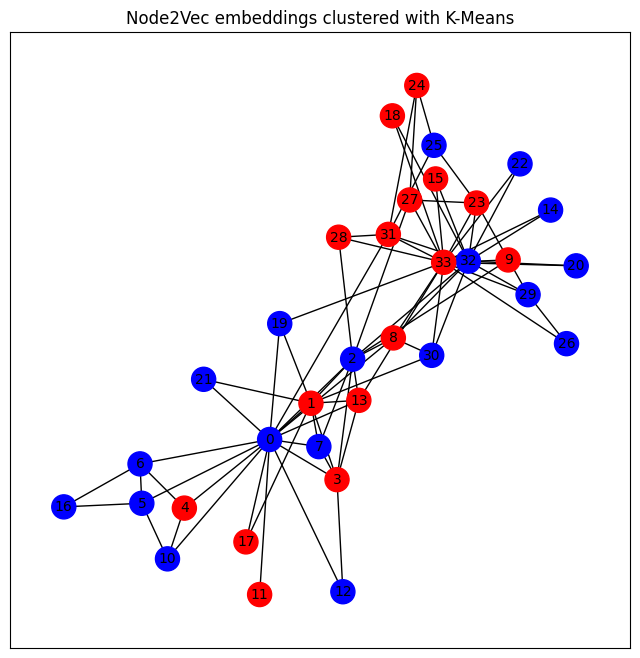

In [9]:
# Initialize Node2Vec model with specified parameters
node2vec = Node2Vec(
    G,
    dimensions=10,   # Reduced dimensionality
    walk_length=120,  # Increased walk length
    num_walks=100,    # Reduced number of walks to balance computation time
    p=1,             # Higher return parameter to explore further parts of the graph
    q=0.5,           # Lower in-out parameter to stay close to the starting node
    workers=20        # Adjust based on CPU
)


# Train the Node2Vec model
model = node2vec.fit(
    window=15,                      # The maximum distance between the current and predicted node in a walk
    min_count=1,                    # The minimum count of nodes to consider when training the model
    batch_words=4                   # The size of batches for training the model
)

# Retrieve embeddings from the model
embeddings = model.wv.vectors

# Perform K-means clustering on the embeddings
kmeans = KMeans(
    n_clusters=2,                   # Number of clusters to form (Karate Club has two factions)
    random_state=42                 # Random state for reproducibility
).fit(embeddings)

# Get the cluster labels for each node
labels = kmeans.labels_

# Create a color map for visualizing different clusters
color_map = {0: 'blue', 1: 'red'}

# Map the labels to colors
colors = [color_map[label] for label in labels]

# Draw the graph with nodes colored according to their cluster assignment
plt.figure(figsize=(8, 8))
nx.draw_networkx(
    G,                              # The graph
    node_color=colors,              # Colors of the nodes
    with_labels=True,               # Show node labels (node IDs)
    node_size=300,                  # Size of the nodes
    font_size=10                    # Font size for node labels
)
plt.title('Node2Vec embeddings clustered with K-Means')
plt.show()
